# Forecasting Seizures From EEG Data: Exploration

#### Author: Burak Himmetoglu

A few years back, a [Kaggle competition](https://www.kaggle.com/c/seizure-prediction) was held where contesters tried to predict onset of epileptic seizures from the EEG data collected from animal and human subjects. The competition was based on data published on several scientific journals. 

In this notebook, I will perform an exploratory analysis and provide strategies on how one can engineer features from the time-series EEG data to be used in machine learning algorithms. 

For the exploration, I will concentrate on the data from one of the dog subjects (Dog_1 in Kaggle). 

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from utils.get_prepare_data import * # Helper functions
%matplotlib inline

In [5]:
# Read data
clips_interictal, clips_preictal, clips_test = get_data(data_folder = r"D:\projects\Data_EEG\Dog_2")

### Interictial vs Preictal Clips

**Preictal** clips correspond to the time-series segments of the measurement before a seizure occurs (usually, segments 90 min before a seiuzure is labeled as preictal). **Interictal** clips are instead segments with no oncoming seizures.  

There are different channels where measurements are performed. In this example, there are 16 channels. In each channel, a sampling frequency determines how many data points are in 1 second (600 Hz in this example). The sampling frequency multiplied with the total measurement time per clip (~400 s in this example) determines the length of each time-series (around 240,000). Let's summarize:

$$ n_{ch} = 16 $$

$$ T = 400\, s $$

$$ f_{s} = 600\, {\rm Hz} $$

Now, let's try to see whether we can find out any clue on how the interictal and preictal clips differ by visual exploration. We first load one interictial and one preictal clip, and visualize the difference by channel.

In [6]:
# First interictial segment
clip_interictal_1 = loadmat(clips_interictal[0])
segment = list(clip_interictal_1.keys())[3] # Get segment name
data_0 = clip_interictal_1[segment][0][0][0]

# First preictal segment
clip_preictal_1 = loadmat(clips_preictal[0])
segment = list(clip_preictal_1.keys())[3] # Get segment name
data_1 = clip_preictal_1[segment][0][0][0]

Let's plot the interictial and preictal segments for all channels

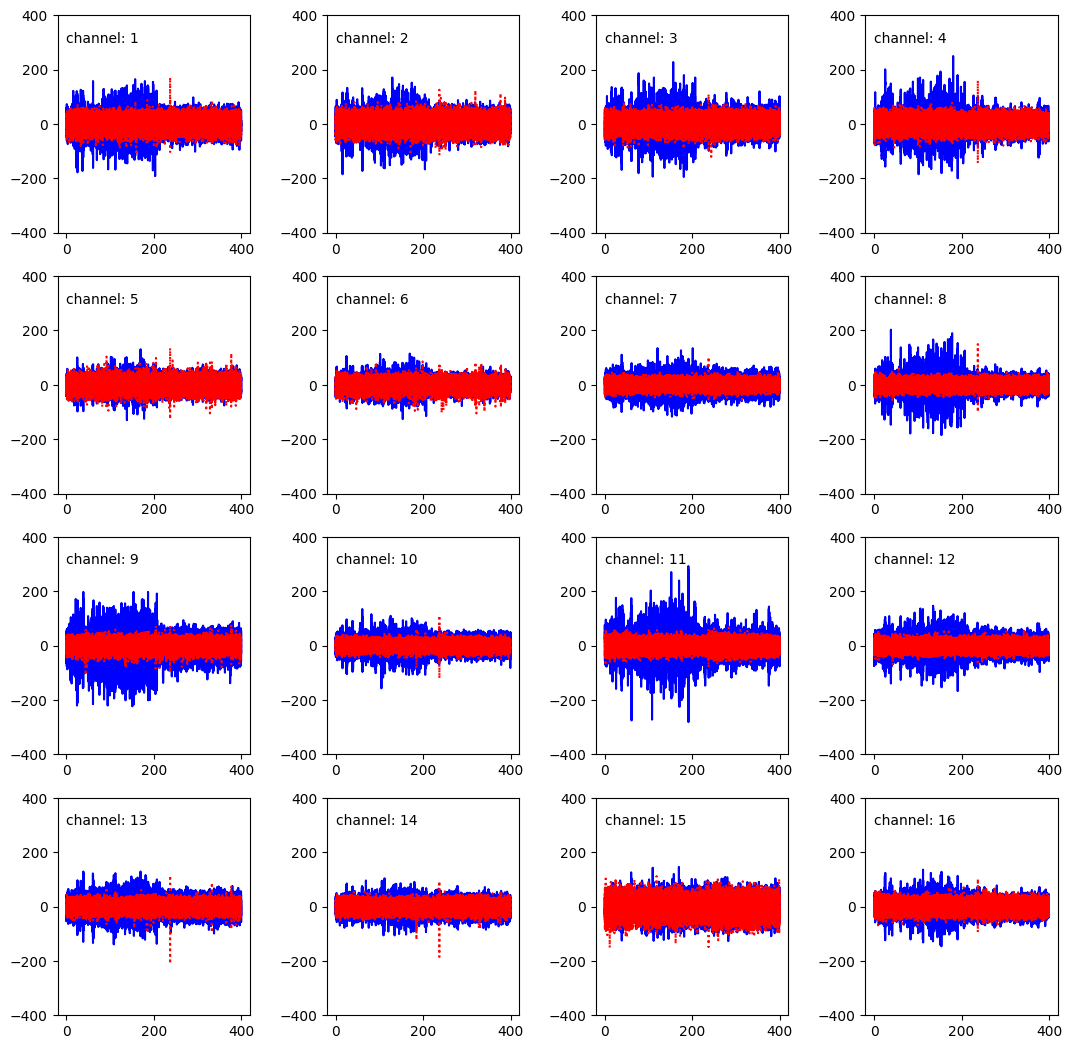

In [7]:
# Set up the figure
data_lenght_sec = np.squeeze(clip_preictal_1[segment][0][0][2]) # Total length in seconds
channels = np.squeeze(clip_preictal_1[segment][0][0][3])
fig = plt.figure(figsize = (10,10)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.4)

# Plot
x = np.linspace(0,data_lenght_sec,data_0.shape[1])
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    l1 = ax.plot(x,data_0[i], color = "blue")
    l2 = ax.plot(x,data_1[i], ls = ':', color = "red")
    ax.set_ylim([-400,400])
    txt = "channel: "+ str(i+1)
    ax.text(0,300,txt)
        

The blue lines represent an interictal segment, while the red lines are preictal. For this particular example, there seem be differences in amplitude on channels 1 and 13. For modelling, we will need to extract features from the time-series, since we cannot use the whole 240,000 data points are features (we have a much smalle number of samples than 240,000)

### Feature Engineering: Basics

Let us first consider the simplets features that one can think of: 

1. Variance within each channel 
2. Correlation between channels 

This will give us the following number of features:

$ n_{ch} $ variances

$ n_{ch} \times (n_{ch}-1)/2 $ correlations (correlation matrix is symmetric)

where $n_{ch}$ is the number of channels (16 in this example). Cycling over all the data, we can construct a design matrix $X$ which contains all the variance and correlation information for all the clips, which is what we do below:

In [8]:
# The meaning will be clear below
freq_bands = np.array([0.1, 4, 8, 12, 30, 70, 180])

# Interictal segments
interictal_feats = Features(clips_interictal, 0, freq_bands)
X_0, Y_0 = interictal_feats.collect(feature_type = "basic")

# Preictal segments
preictal_feats = Features(clips_preictal, 1, freq_bands)
X_1, Y_1 = preictal_feats.collect(feature_type = "basic")

The data has the following dimensions:

In [9]:
print("Interictal clips: ", X_0.shape)
print("Preictal clips: ", X_1.shape)

Interictal clips:  (500, 136)
Preictal clips:  (42, 136)


The number of preictal clips are much smaller, which means that we have to take care while training models, since there is an inbalance in the labels. We will address this later on.

Now, let us normalize the data (mean=0,std = 1) and construct principal components. We can visualize the first two principal components and observe their dependence on the target (preictal or interictial) to gain some insight.

In [7]:
from sklearn import preprocessing

# Combine the data first 
X = np.concatenate((X_0, X_1), axis = 0)
Y = np.concatenate((Y_0, Y_1), axis = 0)
Y = np.squeeze(Y).astype(int) # (N,1) to (N,)

# Scale
X_scl = preprocessing.scale(X)

Now, construct principal components (PC) and plot:

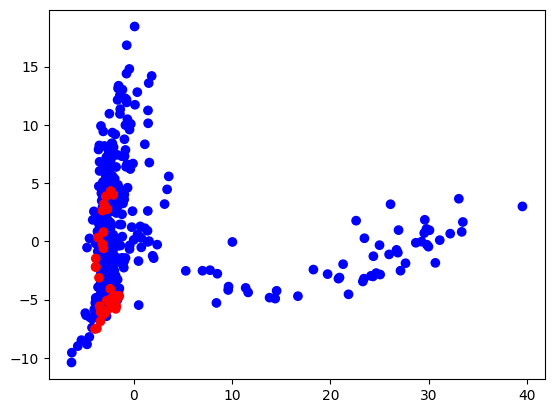

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # Get the first 2
X_pca = pca.fit_transform(X_scl) 

# Plot
color_train = []
for i in range(len(Y)):
    if (Y[i] == 0):
        color_train.append('blue')
    else:
        color_train.append('red')
        
plt.scatter(X_pca[:,0], X_pca[:,1], c = color_train)

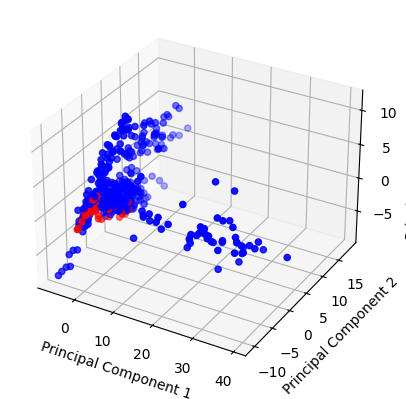

In [10]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting functionality
from sklearn.decomposition import PCA

# Combine the data first
# Combine the data first 
X = np.concatenate((X_0, X_1), axis = 0)
Y = np.concatenate((Y_0, Y_1), axis = 0)
Y = np.squeeze(Y).astype(int) # (N,1) to (N,)

# Scale
X_scl = preprocessing.scale(X)

# Perform PCA with 3 components
pca = PCA(n_components=3)  # Get the first 3
X_pca = pca.fit_transform(X_scl)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define colors based on the class labels
color_train = ['blue' if label == 0 else 'red' for label in Y]

# Scatter plot in 3D
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=color_train)

# Set axis labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()


In [24]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Create the model
lasso = Lasso(alpha=10)

# Fit the model to the training data
lasso.fit(X, y_train)

# Extract the coefficients
lasso_coef = lasso.coef_

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.plot(range(len(X_train.columns)), lasso_coef)
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=60)
plt.axhline(0.0, linestyle='--', color='r')
plt.ylabel('Coefficients')

Selected Feature Indices:
[]


c:\Users\prova\anaconda3\envs\prova\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.344496546742862, tolerance: 0.0037926096997690536
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\prova\anaconda3\envs\prova\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3483350572973336, tolerance: 0.0037926096997690536
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\prova\anaconda3\envs\prova\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28889653978133367, tolerance: 0.0037935483870967747
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\prova\anaconda3\envs\prova\lib\site-p

Notice that the preictal clips (blue) correspond to PCs that span a larger range, while the interictal clips align on a line (red). This already shows some hope that one may find a separating hyperplane that could serve as a good classifier. Let's try a simple linear model with L2 penatly and use 3-folds cross validation (CV) to train it:

In [13]:
from sklearn.linear_model import LogisticRegressionCV
Cvalues = np.logspace(-1,4,10)

# Train over 3 folds
cls = LogisticRegressionCV(Cs = Cvalues, cv = 3, max_iter=150, solver = 'liblinear',
                           penalty = "l2", scoring = 'roc_auc', verbose = 1, 
                           n_jobs = 3, random_state=101)

cls.fit(X_scl,Y)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished


LogisticRegressionCV(Cs=array([1.00000000e-01, 3.59381366e-01, 1.29154967e+00, 4.64158883e+00,
       1.66810054e+01, 5.99484250e+01, 2.15443469e+02, 7.74263683e+02,
       2.78255940e+03, 1.00000000e+04]),
                     cv=3, max_iter=150, n_jobs=3, random_state=101,
                     scoring='roc_auc', solver='liblinear', verbose=1)

The performance metric we use in this case is the area under the ROC curve ([AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)). The CV chooses the best model with the highest AUC, which is:

In [14]:
# Best model
print("Best model C= {:.2e}".format(cls.C_[0]))

# Average CV score
score_mean = np.mean(cls.scores_[1][:, cls.Cs_ == cls.C_[0]])
print("Best model score (average over folds)= {:4f}".format(score_mean))

Best model C= 4.64e+00
Best model score (average over folds)= 0.963129


This is not a great AUC value, but we can definitely do much better with more carefully chosen features. 

Now that we have a simple solution to the problem, we can improve by engineering better features.

### Spectral Power based features (PIB: Power in band)

For this approach, I will follow the [article](https://doi.org/10.1371/journal.pone.0081920) by Howbert et al., which studies forecasting of seizures in dogs. 

Let's look at some of the features we can obtain using the frequency space of the time series. We will construct spectral power in 6 frequency bands. Power will be computed from the Fourier Transform of 1 min blocks of each segment. This increases the number of data instance per segment, which is also useful for reducing the variance of the models we train.

Now, recall that the segment is 400s long, and the sampling frequency is 600 Hz. This means that if we have 60 sec bloks, we will obtain 400//60 = 6 data instances. Schematically, this looks like:

![title](img/eeg.001.png)

The power spectrum (i.e. absolute value of the Fourier transform in this particular case) will be computed in the following frequency bands:

[0.1,4], [4,8], [8,12], [12,30], [30,70], [70,180] Hz

i.e. 6 bands. Computing power in each band for each channels(16 of them) yields 6x16=96 features for a single block. Thus, from a single segment, we obtain the following contribution to the design matrix:

$$ X \in {\mathbb R}^{n_{blocks} \times n_{bands}\cdot n_{ch}} = {\mathbb R}^{6\times 96} $$ 

with the targets 

$Y = {\rm ones}(6)$ for preictal, and $Y = {\rm zeros}(6)$ for interictial.

Now, given that we have 6 blocks per segment, our design matrix will have 6 times more data instances! Let's collect all the data:

In [4]:
X_0, Y_0 = interictal_feats.collect(feature_type = "PIB")
X_1, Y_1 = preictal_feats.collect(feature_type = "PIB")

In [5]:
print("New size for preictal data: ", X_1.shape)
print("New size for interictal data: ", X_0.shape)

New size for preictal data:  (144, 96)
New size for interictal data:  (2880, 96)


Now we can use these to train a model. Let's try the linear model again:

In [6]:
# Combine the data first 
X = np.concatenate((X_0, X_1), axis = 0)
Y = np.concatenate((Y_0, Y_1), axis = 0)
Y = np.squeeze(Y).astype(int) # (N,1) to (N,)

# Scale
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV
X_scl = preprocessing.scale(X)

# Train over 3 folds
Cvalues = np.logspace(-1,4,10)
cls = LogisticRegressionCV(Cs = Cvalues, cv = 3, max_iter=200, solver = 'liblinear',
                           penalty = "l2", scoring = 'roc_auc', verbose = 1, 
                           n_jobs = 3, random_state=101)

cls.fit(X_scl,Y)

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished


LogisticRegressionCV(Cs=array([  1.00000e-01,   3.59381e-01,   1.29155e+00,   4.64159e+00,
         1.66810e+01,   5.99484e+01,   2.15443e+02,   7.74264e+02,
         2.78256e+03,   1.00000e+04]),
           class_weight=None, cv=3, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=200, multi_class='ovr',
           n_jobs=3, penalty='l2', random_state=101, refit=True,
           scoring='roc_auc', solver='liblinear', tol=0.0001, verbose=1)

In [7]:
# Best model
print("Best model C= {:.2e}".format(cls.C_[0]))

# Average CV score
score_mean = np.mean(cls.scores_[1][:, cls.Cs_ == cls.C_[0]])
print("Best model score (average over folds)= {:4f}".format(score_mean))

Best model C= 2.78e+03
Best model score (average over folds)= 0.696549


Worse AUC!! This could be related to the fact that we have a smaller number of features in this case, and we have not included inter-channel and inter-band correlations. We only kept the power within a single band. The next step would be to construct more features.

### Extended features

As seen above, we need a larger number of features that capture inter and intra channel correlations between bands within segments. Construction of these features are adapted from a [Matlab solution](https://github.com/drewabbot/kaggle-seizure-prediction). Similar to PIB,
each segment in split into blocks of 60s. Within each block, power spectra within 6 frequency bands (see above) are computed. These power
spectra are used to consruct the following features

* Eigenvalues of the correlation matrix between bands and channels within each block
* Shannon's entropy for the power within each block
* Power at dyadic levels, the eigenvalues of their correlation between channels and Shannon's entropy
* [Hjorth parameters](https://en.wikipedia.org/wiki/Hjorth_parameters)
* Skewness and Kurtosis within each block

Now, let's construct them

In [15]:
# Collect features
from utils.get_prepare_data_full import * # Full features
freq_bands = np.array([0.1, 4, 8, 12, 30, 70, 180])

X_0, Y_0, _ = features(clips_interictal, 0, freq_bands)
X_1, Y_1, _ = features(clips_preictal, 1, freq_bands)

In [4]:
# Let's combine
X = np.concatenate((X_0, X_1), axis=0)
Y = np.squeeze(np.concatenate((Y_0, Y_1), axis=0)).astype(int)

Now, let's train the linear model again:

In [5]:
# Scale
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV

X_scl = preprocessing.scale(X)

# Train over 3 folds
Cvalues = np.logspace(-1,4,10)
cls = LogisticRegressionCV(Cs = Cvalues, cv = 3, max_iter=200, solver = 'liblinear',
                           penalty = "l2", scoring = 'roc_auc', verbose = 1, 
                           n_jobs = 3, random_state=101)

cls.fit(X_scl,Y)

/Users/corellia/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:920: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.0s finished


LogisticRegressionCV(Cs=array([  1.00000e-01,   3.59381e-01,   1.29155e+00,   4.64159e+00,
         1.66810e+01,   5.99484e+01,   2.15443e+02,   7.74264e+02,
         2.78256e+03,   1.00000e+04]),
           class_weight=None, cv=3, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=200, multi_class='ovr',
           n_jobs=3, penalty='l2', random_state=101, refit=True,
           scoring='roc_auc', solver='liblinear', tol=0.0001, verbose=1)

In [6]:
# Best model
print("Best model C= {:.2e}".format(cls.C_[0]))

# Average CV score
score_mean = np.mean(cls.scores_[1][:, cls.Cs_ == cls.C_[0]])
print("Best model score (average over folds)= {:4f}".format(score_mean))

Best model C= 1.67e+01
Best model score (average over folds)= 0.752308


Getting better! We will definitely need more work for better performance..